## Makemore Part 2: MLP
## Best result: 2.1447 dev loss, 2.1379 train loss, beating Andrej's 2.20 dev loss challenge
- Increased context size to 4
- Implemented an extra part from the paper of connecting word features directly to final layer
- Used PyTorch SGD optimizer with a step scheduler, gamma=0.1 every 10k steps

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Idea from paper: C is a lookup table (matrix) for embeddings vector of each of the words in V e.g |V|=17k
- C: (17000x30)
- one-hot encoding of a word: (1x17000)
- enc @ C -> (1x30) embedding vector

We can get these vectors for multiple input words (words that came before).

Pass them to neurons with n_in=30, those neurons are fully connected to a hidden layer, then goes through tanh -> softmax for probabilities.

Final output: 17k vector of probabilities for the 17k words in vocab.
- Train by using actual next word's index, get the predicted prob, do -log(prob) and backprop etc.

---

We can use this idea for a character-level model as well.

## Architecture
- Start with indexes from the chars/words in context
- Convert them to respective embeddings vectors in C (lookup)
- Stack the vectors' values together, do forward pass with weights matrix and add bias
- Activate through tanh
- Pass through one more layer to get 27 outputs (one for each unique char in our vocab)
- Softmax to get probabilities

## Building dataset
Hyperparameter: BLOCK_SIZE = 3
- block_size is the number of previous chars we consider when predicting next

For each word, we add to X with block_size=3 char windows, Y has the char that comes after
- e.g '.emma': (..., e), (..e, m), (.em, m), (emm, a), (mma, .)
- So each word contributes n+1 examples as before, n = len(word)

## Lookup table
Lookup table: C = (27,2) random init
- In paper, they compress 17k words of vocab into Rn of n=30
- So we do similar here for 27 unique chars -> embeddings of size 2

Previously, we used one-hot encoding to lookup with enc @ W
- But this is just the same as doing W[idx] due to all the zeroes

In PyTorch, we can just do C[X] and it will work
- produces (32,3,2) - one 2D vector for each encoded char
- Or another way to think about it, one (3x2) vector for each row in X. 3 because BLOCK_SIZE=3, so each row in X has 3 elements. For each of those chars, we want one 2D vector - its embedding

## F.cross_entropy
F.cross_entropy(logits, targets) is the same as doing:

```python
logits = logits.softmax(dim=1)
logits = logits[torch.arange(M), Y]
nll_loss = -logits.log().mean()
```
i.e same as softmax -> select corresponding probabilities for targets in Y -> get NLL Loss (mean)

F.cross_entropy is **better** because PyTorch can optimise and not create new memory, and it can use **fused kernels** to cluster ops together and run them at the same time.
- Also more numerically stable. logits can be subtracted or added by any number. when logits are too high, e^(high number) becomes inf, then we get nans. But PyTorch can internally subtract the data by the max number to prevent this

## Batching
Instead of fwd + backward on whole dataset which is slow, we can pick a random batch each time and fwd + backward on that.
Just select BATCH_SIZE of random indices within [0,M), then use X[batch_indices] and Y[batch_indices]

## Finding good learning rate
1. Find min and max bounds by trial and error
- Set very low LR, low is if it barely changes
- High is if loss grows
2. Create torch.linspace between low and high using exponents for the lrs e.g -3, 0 for 10^-3 -> 10^0=1
3. During loop, ith iteration uses ith LR in list for the batch. Track the loss for that LR
4. Graph it and find the valley in the graph - the middle should be a good LR.

## Train, test, validation split (80,10,10)
Train split: Used to optimise model parameters with gradient descent

Validation split: Used to tune hyperparameters: e.g outputs in hidden layers, size of embeddings in C
  
Test split: Used to evaluate the performance of the model at the **end**
- Why: achieving low loss on the same set we used to train isn't necessarily a good thing. Because when we use bigger models, they are able to just memorise the dataset, then doesn't generalise to new inputs well.

Training: we tune hyperparameters by checking repeatedly on dev split, then at the end check loss against test split just one time and this is the final number we report.

## Overfitting, underfitting
Underfitting: when train loss and dev or test loss are both high and close to each other
- Means the model isn't big enough / powerful enough to fit the data

Overfitting: when train loss is low, but dev/test loss are much higher
- Means the model is memorising the training data but doesn't generalise well

In [205]:
from collections import Counter
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## Build the dataset

In [44]:
# Open up names
names = []
with open('names.txt', 'r') as names_file:
  names = names_file.read().splitlines()

print("Total length:", len(names))

# Hyperparameters
BLOCK_SIZE = 3
EMBEDDING_SIZE = 10


# build lookups
uniq = ['.'] + sorted(list(set(''.join(names))))
stoi = { char: idx for idx, char in enumerate(uniq)}
itos = { idx: char for char,idx in stoi.items() }

# unique tokens to predict
VOCAB_SIZE = len(uniq)

def build_dataset(names):
    X = []
    Y = []
    
    for word in names:
      # print(word)
      word = word + '.'
      block = [0] * BLOCK_SIZE # ... (empty context at start)
    
      for char in word:
        char_idx = stoi[char]
        X.append(block)
        Y.append(char_idx)
    
        block_str = ''.join(list(map(lambda i: itos[i], block)))
        # print(f'{block_str} -> {char}')
    
        # update block: roll over sliding window
        block = block[1:] + [char_idx]

    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y


# train, test, dev split: 80,10,10
from random import Random
Random(42).shuffle(names)

print(names[0:5])

n_80 = int(0.8*len(names))
n_90 = int(0.9*len(names))
print(n_80, n_90)

Xtr, Ytr = build_dataset(names[:n_80]) # 80%
Xdev, Ydev = build_dataset(names[n_80:n_90]) # 10%
Xtest, Ytest = build_dataset(names[n_90:]) # 10%

Total length: 32033
['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
25626 28829


In [46]:
total = len(Xtr) + len(Xdev) + len(Xtest)
print(total)
print(len(Xtr) / total)
print(len(Xdev) / total)
print(len(Xtest) / total)
print(len(Xtr) , len(Xdev), len(Xtest))

228146
0.8004742577121667
0.09930044795876325
0.10022529432906999
182625 22655 22866


In [48]:
print(Xtr.shape, Ytr.shape, Xtr.dtype, Ytr.dtype)
print(Xtr)
print("---")
print(Ytr)

torch.Size([182625, 3]) torch.Size([182625]) torch.int64 torch.int64
tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])
---
tensor([25, 21,  8,  ...,  1, 14,  0])


## Putting it together

In [99]:
#--SETUP--#

# Generator
GEN = torch.Generator().manual_seed(2147483647)
# Number of examples
M = len(Xtr) 

# Params: C, W, bias, W2, b2
# Lookup table
    # 27 rows: one for each unique char
    # 2 cols: m=2 embeddings vectors.
C = torch.randn(VOCAB_SIZE, EMBEDDING_SIZE, generator=GEN)

# Forward pass
W_OUT = 200

# First layer
W = torch.randn((BLOCK_SIZE * EMBEDDING_SIZE), W_OUT, generator=GEN) # (6,100)
bias = torch.randn(W_OUT, generator=GEN) # (1,100): 1 bias per neuron (per column)

# Second layer: W_OUT inputs, 27 outputs for log-counts (to become probabilities)
W2 = torch.randn((W_OUT, VOCAB_SIZE), generator=GEN) * 0.01
b2 = torch.randn(VOCAB_SIZE, generator=GEN) * 0

# W3 = torch.randn((BLOCK_SIZE * EMBEDDING_SIZE, VOCAB_SIZE), generator=GEN)

parameters = [C, W, bias, W2, b2]

for param in parameters:
    param.requires_grad=True

Loss: 3.32205867767334
Loss: 3.1857101917266846
Loss: 3.1329588890075684
Loss: 3.0528512001037598
Loss: 3.1373000144958496
Loss: 3.1373000144958496


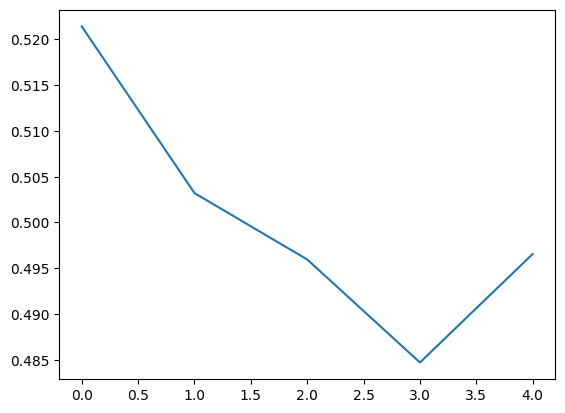

In [101]:
#--TRAINING--#
import torch.optim

EPOCHS=5
LR=0.1
BATCH_SIZE=32

optimizer = torch.optim.SGD(parameters, lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)


epochs = []
losses = []

for i in range(EPOCHS):
    optimizer.zero_grad()
    
    # select a random batch and use that for fwd + backward for faster iteration
    # batch_indices = torch.randperm(len(Xtr), generator=GEN)
    # batch_indices = batch_indices[:BATCH_SIZE]
    batch_indices = torch.randint(0, Xtr.shape[0], (32,), generator=GEN)

    emb = C[Xtr[batch_indices]] # lookup embeddings corresponding to each row -> (M, BLOCK_SIZE, 2) i.e one 2D vector per char in a row of X

    # view shares the same underlying elements, just rearranges logically
        # (number of examples, number of elems per example)
    emb_view = emb.view((emb.shape[0], BLOCK_SIZE * EMBEDDING_SIZE))
    
    # forward pass: get linear combs + bias for each row, activate with tanh
    h = emb_view @ W
    h = h + bias
    h = h.tanh()
    
    # forward pass 2nd layer to get 27 outputs per row
    probs = h @ W2 + b2
    # probs = probs + emb_view @ W3
    
    # this is the same as doing probs.softmax, selecting corresponding probabilities with [arange(M), Y], then doing NLL and mean. but better
    nll_loss = F.cross_entropy(probs, Ytr[batch_indices])
    
    epochs.append(i)
    print("Loss:", nll_loss.item())
    losses.append(nll_loss.log10().item())
    # --Update--#

    nll_loss.backward()

    optimizer.step()
    scheduler.step()

    
    
    # for param in parameters:
    #     param.grad = None
    
    # # backward pass
    # nll_loss.backward()
    
    # # update
    # with torch.no_grad():
    #     for param in parameters:
    #         param -= LR * param.grad
            
print("Loss:", nll_loss.item())

plt.plot(epochs, losses)

## Get loss for dev split

In [97]:
emb = C[Xdev]
emb_view = emb.view((emb.shape[0], BLOCK_SIZE * EMBEDDING_SIZE))
# forward pass: get linear combs + bias for each row, activate with tanh
h = emb_view @ W
h = h + bias
h = h.tanh()

# forward pass 2nd layer to get 27 outputs per row
probs = h @ W2 + b2

# probs = probs + emb_view @ W3
print(probs.shape)

# same as cross_entropy nll_loss
# t = probs.softmax(dim=1)
# t = t[torch.arange(Xdev.shape[0]), Ydev]
# t = -t.log().mean()
# print(t)


# this is the same as doing probs.softmax, selecting corresponding probabilities with [arange(M), Y], then doing NLL and mean. but better
nll_loss = F.cross_entropy(probs, Ydev)
nll_loss

torch.Size([22655, 27])


tensor(2.8392, grad_fn=<NllLossBackward0>)

## Loss for test split

In [26]:
emb = C[Xtest]
emb_view = emb.view((emb.shape[0], BLOCK_SIZE * EMBEDDING_SIZE))
# forward pass: get linear combs + bias for each row, activate with tanh
h = emb_view @ W
h = h + bias
h = h.tanh()

# forward pass 2nd layer to get 27 outputs per row
probs = h @ W2 + b2

# probs = probs + emb_view @ W3

# this is the same as doing probs.softmax, selecting corresponding probabilities with [arange(M), Y], then doing NLL and mean. but better
nll_loss = F.cross_entropy(probs, Ytest)
nll_loss

tensor(2.2864, grad_fn=<NllLossBackward0>)

In [1205]:
X,Y = build_dataset(names)

emb = C[X]
emb_view = emb.view((emb.shape[0], BLOCK_SIZE * EMBEDDING_SIZE))
# forward pass: get linear combs + bias for each row, activate with tanh
h = emb_view @ W
h = h + bias
h = h.tanh()

# forward pass 2nd layer to get 27 outputs per row
probs = h @ W2 + b2

# probs = probs + emb_view @ W3

# this is the same as doing probs.softmax, selecting corresponding probabilities with [arange(M), Y], then doing NLL and mean. but better
nll_loss = F.cross_entropy(probs, Y)
nll_loss

tensor(2.1105, grad_fn=<NllLossBackward0>)

## Sample from model

In [1284]:
def get_word(max_count=10):
    current_block = [0] * BLOCK_SIZE
    string = []

    for i in range(max_count):
        emb = C[current_block].view(1, BLOCK_SIZE * EMBEDDING_SIZE)
        
        # fwd pass
        h = emb @ W + bias
        h = h.tanh()
    
        probs = h @ W2 + b2
        
        probs = probs + emb @ W3
        

        # turn into probabilities
        probs = probs.softmax(dim=1)
        
    
        sampled = torch.multinomial(probs, num_samples=1, replacement=True, generator=GEN)
        sampled_idx = sampled.item()
        char = itos[sampled_idx]

        if char == '.':
            break

        string.append(char)

        current_block = current_block[1:] + [sampled_idx]


    return ''.join(string)
    


for i in range(20):
    word = get_word()
    s = f'name : {word}       | is in tr data: {word in names[:n_80]}'
    print(s)

name : euth       | is in tr data: False
name : maria       | is in tr data: True
name : szem       | is in tr data: False
name : hathilini       | is in tr data: False
name : doura       | is in tr data: False
name : breviana       | is in tr data: False
name : maetarylei       | is in tr data: False
name : kana       | is in tr data: True
name : pametsa       | is in tr data: False
name : aran       | is in tr data: True
name : bryeah       | is in tr data: False
name : zanaylin       | is in tr data: False
name : kariex       | is in tr data: False
name : saunesty       | is in tr data: False
name : niqie       | is in tr data: False
name : lyah       | is in tr data: True
name : darliz       | is in tr data: False
name : novirell       | is in tr data: False
name : hernie       | is in tr data: False
name : avakellee       | is in tr data: False


In [251]:
# a = torch.randn(20)
a = torch.zeros(20)
print(a)
a = a.softmax(dim=0)
print(a)
-a.log()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500])


tensor([2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957,
        2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957, 2.9957,
        2.9957, 2.9957])

tensor(6.9078)

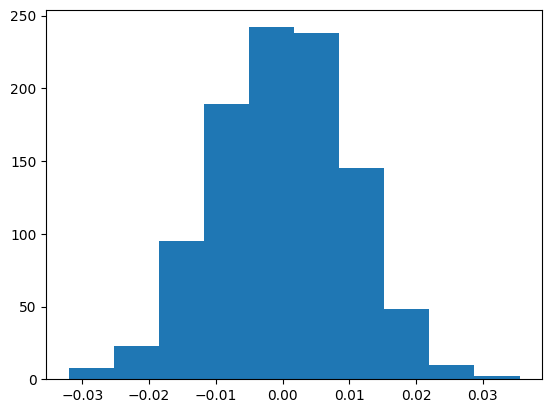

In [485]:
# a = torch.zeros(10)
# a = torch.zeros(1000) # [2,2,2,..]
a = torch.randn(1000) / 100
p = plt.hist(a)
# print(a[0:10])


a = a.exp() # (e^k) / 100, ...
# print(a[0:10])

a = a / a.sum() # e^2 / 10e^2 = 1/10 = 0.1, 0.1, 0.1


# # print(a)
# # -> 
a  = -a.log()


a.mean()

In [449]:
-torch.Tensor([1/1000]).log()

tensor([6.9078])